# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>


In this exercise I investigate the parallelization of a **Genetic Algorithm (GA)** applied to the **Travelling Salesman Problem (TSP)** using the **OpenMPI** library.  

The notebook is structured in three parts:

- [Parallel computing](#parallel-computing)  
- [Implementation](#implementation)  
- [Results](#results)  


# Parallel computing

Parallel computing is not only a way to make programs faster; it also enables better science and better solutions. In fact, by distributing independent stochastic runs over multiple processes (SPMD paradigm), we obtain diversity of trajectories and robust statistics (variance estimates, confidence bands), which helps diagnose premature convergence and improves the chance of escaping local minima—crucial for heuristic solvers such as Genetic Algorithms (GAs).

In this exercise we use MPI (via the OpenMPI implementation) in a Single Program Multiple Data (SPMD) layout: every process runs the same executable, receives a unique rank in MPI_COMM_WORLD, and proceeds with independent work until synchronization points. The canonical lifecycle is MPI_Init → work/communication → MPI_Finalize; process identity and team size are obtained with MPI_Comm_rank and MPI_Comm_size. When sharing small amounts of data among all processes, collectives provide convenient and efficient coordination. 

For metaheuristics like the GA on TSP, parallelization increases solution quality and reliability (by ensembling many searches), not just throughput. We will exploit this with an island model where long compute phases are punctuated by brief, collective exchanges of elites.

# Implementation

SPMD layout. We launch up to $p≤11$ processes. Each rank is an independent Continent running the same GA code with rank-dependent seeding to guarantee statistical independence. Initialization follows the MPI standard (MPI_Init, MPI_Comm_rank, MPI_Comm_size), then the GA proceeds through generations locally. Output files are rank-scoped so that diagnostics can be aggregated post-hoc.

Migration policy (lightweight, infrequent). Every $100$ generations, each rank exports the genes of its current best chromosome (integer vector of length $N$ city). We use a single collective:

Each process packs its elite as a contiguous std::vector<int> and calls MPI_Allgather, receiving an array of size 
$ p×N $ city with one elite per rank.

Locally, each process reconstructs the imported chromosomes (excluding its own), evaluates their loss with the current distance matrix, and sorts them by fitness.

The process then replaces a corresponding number of its worst individuals with the best imported ones and re-sorts the population.

This design keeps messages small (only elites), rare (every 100 generations), and uses one blocking collective for synchronization.

# Results



## Experimental setup 
Both regimes use **identical GA hyperparameters**; the only difference is inter-process communication:

- Crossover probability: $p_c = 0.6$  
- Mutation probability (per individual): $p_m^{(i)} = 0.05$  
- Population size: $N_{\text{pop}} = 2000$  
- Number of generations: $N_{\text{gen}} = 1000$  
- Elitism (*Heritability*): $\eta = 10\%$

**no_message:** Each MPI rank evolves independently (island model **without** migration). All ranks $0 \ldots p-1$ are plotted to visualize the heterogeneity of trajectories across independent searches.

**message:** The same GA executes on each rank, but **every $100$ generations** ranks **exchange their current elite individual** via the collective **MPI_Allgather**. For visualization, **only rank 0 is plotted**, while the **minimum loss for all ranks** is printed to assess dispersion.


For each rank we record, across generations: (i) the **best-of-run loss** and (ii) the **mean loss of the best half** of the population. Final comparisons focus on the per-rank best loss and its distribution across ranks (median, spread).

For the geographic visualization of the tours we used the **GeoPandas** library to overlay the computed paths on Italian borders.  
The shapefile of national boundaries was downloaded from the freely available  [Natural Earth Data](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/)  dataset.



## Comparative findings

- **no_message (isolated islands):** Convergence is heterogeneous across ranks; several runs plateau at distinct local optima, reflecting limited diffusion of useful building blocks despite the large $N_{\text{pop}}$.  
- **message (elite migration via MPI_Allgather):** We typically observe **faster convergence**, **lower final best loss on average**, and **reduced inter-rank variance**. Improvements often occur in **steps** synchronized with migration epochs, consistent with elite building blocks propagating across islands.




In [20]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

def plot_geo(folder, n):
    """
    Plots (loss & mean-loss) and the TSP path.
    - Always PRINTS the minimum loss reached by ALL processes (0..n-1).
    - If folder == "no_message": plots ONLY process 0 (two panels).
      Otherwise: plots all processes 0..n-1.
    """
    # --- which processes to plot ---
    plot_indices = [0] if folder == "message" else list(range(n))
    print_indices = list(range(n))  # always print for all

    # --- print min loss for all processes ---
    print(f"[{folder}] Minimum loss per process:")
    for proc in print_indices:
        loss = np.loadtxt(f'{folder}/OUTPUT/loss_gen{proc}.dat')
        min_loss = float(np.min(loss))
        print(f"  - Process {proc}: min loss = {min_loss:.6f}")

    # --- load Italy shapefile once ---
    shapefile_path = 'shape/ne_110m_admin_0_countries.shp'
    world = gpd.read_file(shapefile_path)
    italy = world[world['NAME'] == 'Italy']

    # --- figure ---
    nrows = len(plot_indices)
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 8*nrows), squeeze=False)

    for row_idx, proc in enumerate(plot_indices):
        # --- load series for the plotted process ---
        loss = np.loadtxt(f'{folder}/OUTPUT/loss_gen{proc}.dat')
        mean = np.loadtxt(f'{folder}/OUTPUT/mean_loss{proc}.dat')
        min_loss = float(np.min(loss))

        # left: loss curves
        ax_l = axes[row_idx, 0]
        ax_l.plot(loss, label='loss')
        ax_l.plot(mean, label='mean best-half')
        ax_l.text(0.02, 0.95, f'min={min_loss:.4f}\nfinal={loss[-1]:.4f}',
                  transform=ax_l.transAxes, va='top', ha='left')
        ax_l.set_title(f'Process {proc} - Loss')
        ax_l.grid(True)
        ax_l.legend()

        # right: geographic path (file: first 2 rows are headers; cols: idx, x, y)
        x, y = np.loadtxt(f'{folder}/OUTPUT/path{proc}.dat',
                          usecols=(1, 2), skiprows=2, unpack=True)
        ax_r = axes[row_idx, 1]
        italy.plot(ax=ax_r, color='white', edgecolor='black')
        ax_r.plot(x, y, 'o', markersize=5, label="city")
        ax_r.plot(x, y, '-',color='red', linewidth=1.5, label="path")
        ax_r.plot(x[0], y[0], marker='*',color='yellow', markersize=15, label="start")
        ax_r.set_title(f'PATH {proc}')
        ax_r.grid(True)
        ax_r.legend()

    plt.tight_layout()
    plt.show()


[no_message] Minimum loss per process:
  - Process 0: min loss = 55.842900
  - Process 1: min loss = 74.386600
  - Process 2: min loss = 71.421700
  - Process 3: min loss = 75.497200
  - Process 4: min loss = 65.467000
  - Process 5: min loss = 64.663000
  - Process 6: min loss = 65.313100
  - Process 7: min loss = 63.987600
  - Process 8: min loss = 58.420000
  - Process 9: min loss = 64.289200
  - Process 10: min loss = 59.969400


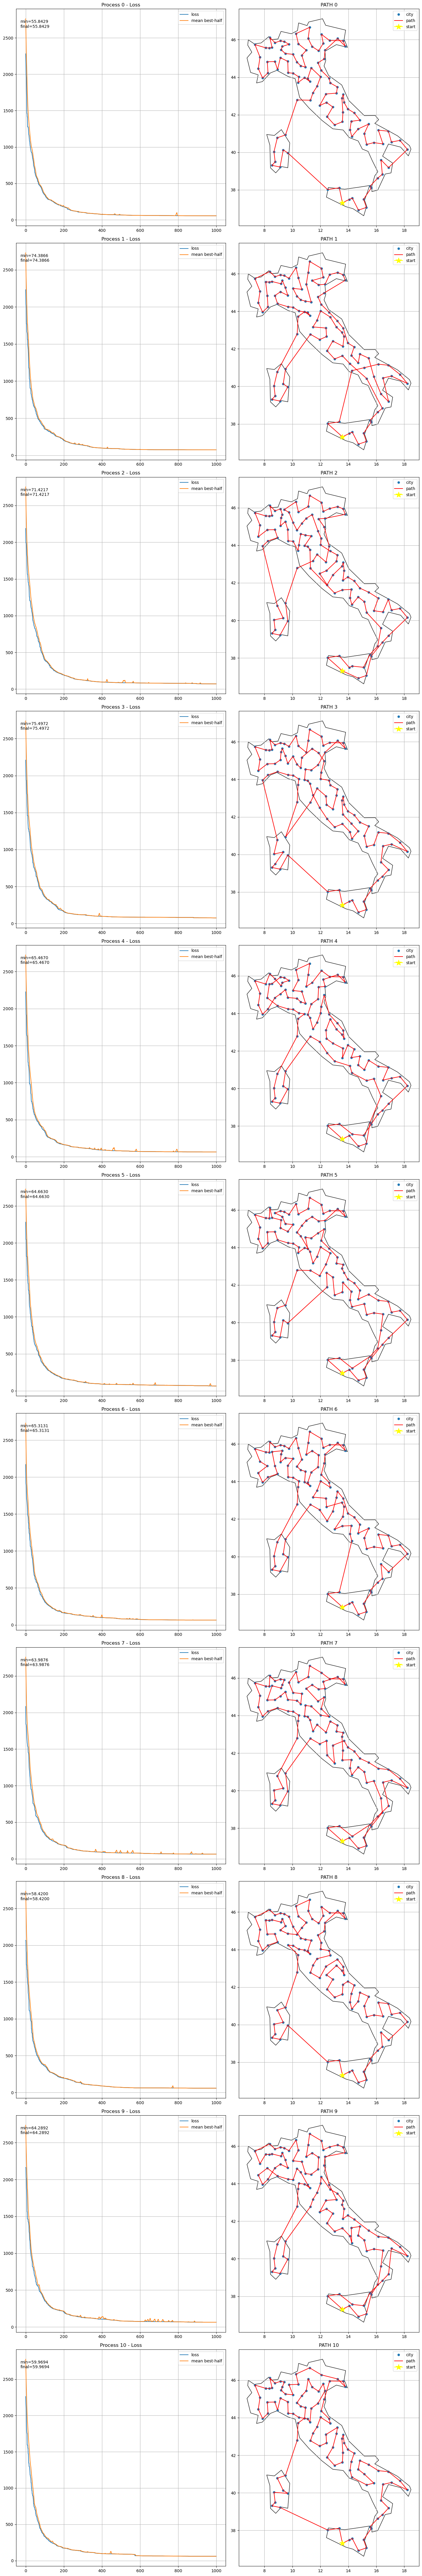

In [21]:
plot_geo('no_message',11)

**Figure 1:** 
Each row corresponds to one MPI rank (continent). **Left:** evolution of the best-of-run loss and the mean loss of the best half of the population over 1000 generations; the inset reports the rank’s minimum loss. **Right:** best tour recovered on the Italy map (points = cities, red line = path, star = start). Hyperparameters are identical across ranks: $p_c=0.6$ , $p_m^{(i)}=0.05$ , $N_{\text{pop}}=2000$ , elitism $=10\%$ . The heterogeneous trajectories and tours illustrate diverse convergence behavior and occasional plateaus in the absence of migration.


[message] Minimum loss per process:
  - Process 0: min loss = 54.419900
  - Process 1: min loss = 54.419900
  - Process 2: min loss = 54.419900
  - Process 3: min loss = 54.419900
  - Process 4: min loss = 54.419900
  - Process 5: min loss = 54.419900
  - Process 6: min loss = 54.419900
  - Process 7: min loss = 54.419900
  - Process 8: min loss = 54.419900
  - Process 9: min loss = 54.419900
  - Process 10: min loss = 54.419900


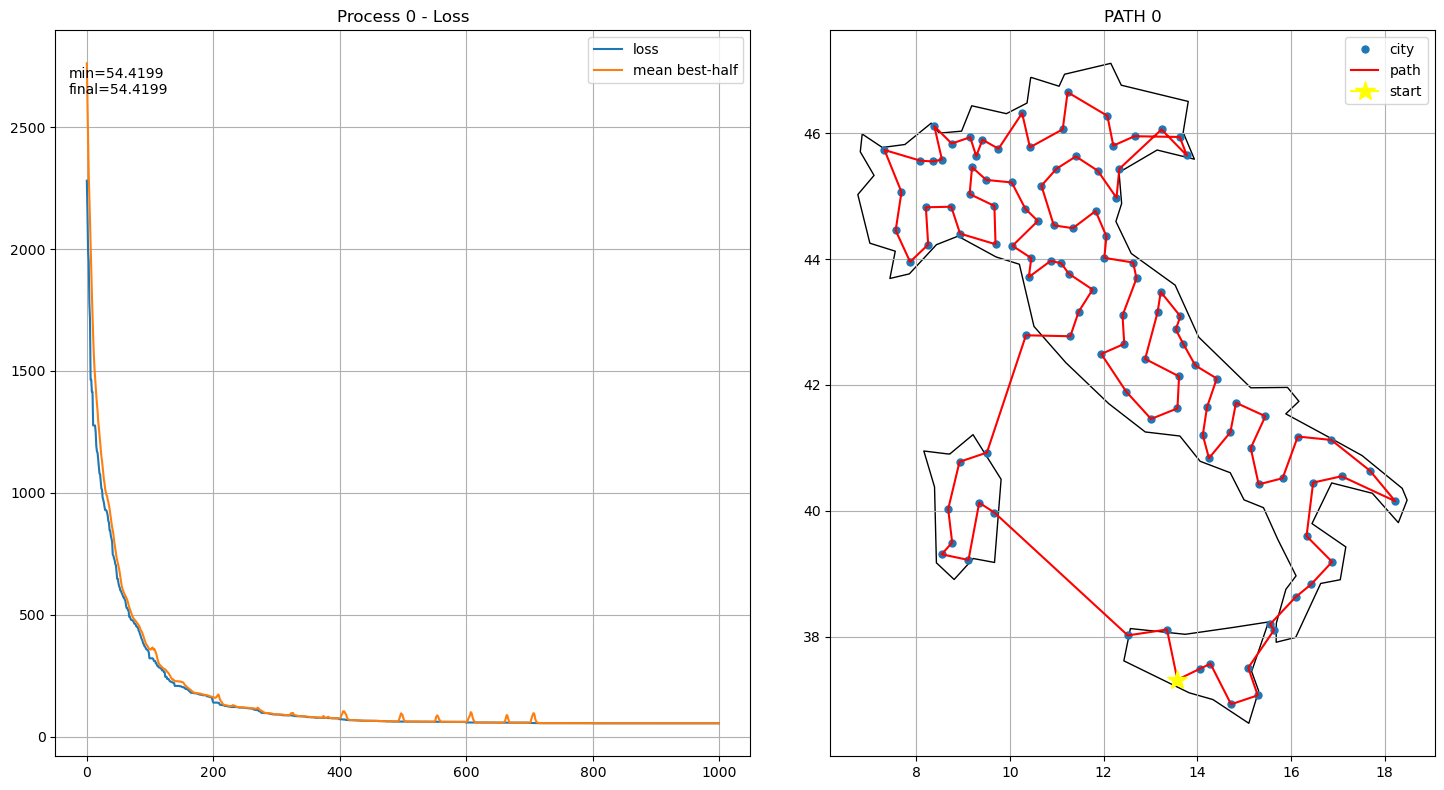

In [22]:
plot_geo('message',11)

**Figure 2 — GA with inter-process messaging (*message*).**  
Results correspond to runs with periodic migration among islands. **Left:** evolution of the best-of-run loss and the mean loss of the best half of the population over 1000 generations for rank 0 (representative plot); the inset shows the minimum loss reached. **Right:** best tour recovered on the Italy map (points = cities, red line = path, star = start). The GA parameters are the same as in Figure 1,  generations ranks exchange their elites using MPI_Allgather. 